In [1]:
import matplotlib.pyplot as plt
from src.dataset import ADE20KDataset, WallADE20KDataset, SimpleWallADE20KDataset
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from pprint import pprint

In [2]:
def display_sample_information(dataset, idx, show_mask=True):
    image, mask = dataset[idx]
    scene = dataset.index['scene'][idx]
    folder = dataset.index['folder'][idx]
    filename = dataset.index['filename'][idx]

    if image.shape[0] == 3:
        image = image.transpose((1, 2, 0))

    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'{scene}: {folder}/{filename}')

    if show_mask:
        if len(mask.shape) == 3:
            mask = mask.squeeze(axis=0)
        plt.figure()
        plt.imshow(mask)
        plt.axis('off')

In [3]:
DATA_ROOT = "../dataset/ADE20K_2021_17_01"

In [4]:
all_dataset = ADE20KDataset(DATA_ROOT, mode='all')
len(all_dataset)

27574

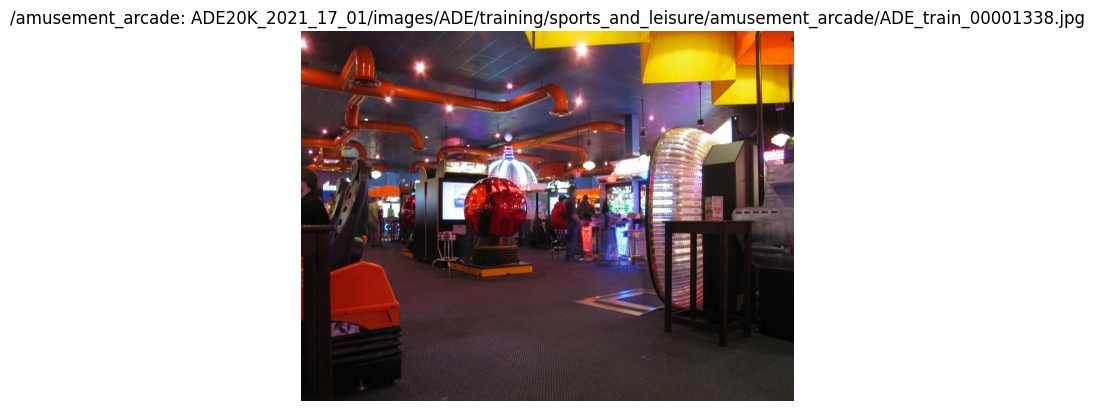

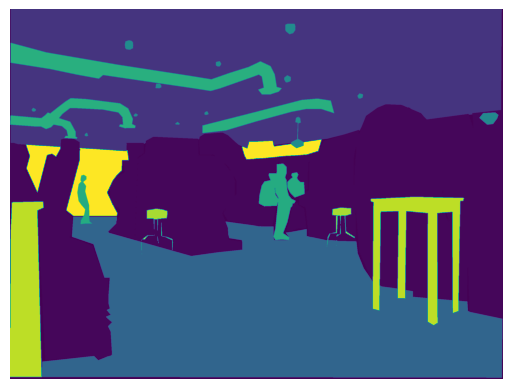

In [5]:
display_sample_information(all_dataset, 1337)

In [6]:
train_dataset = ADE20KDataset(DATA_ROOT, mode='train')
len(train_dataset)

25574

In [ ]:
display_sample_information(train_dataset, 0)

In [ ]:
val_dataset = ADE20KDataset(DATA_ROOT, mode='val')
len(val_dataset)

In [ ]:
display_sample_information(val_dataset, 555)

In [ ]:
train_simple_wall_dataset = SimpleWallADE20KDataset(DATA_ROOT, mode='train')
len(train_simple_wall_dataset)

In [ ]:
val_simple_wall_dataset = SimpleWallADE20KDataset(DATA_ROOT, mode='val')
len(train_simple_wall_dataset)

In [ ]:
display_sample_information(train_simple_wall_dataset, 1337)

In [4]:
all_simple_wall_dataset = SimpleWallADE20KDataset(DATA_ROOT, mode='all')
len(all_simple_wall_dataset)

14701

In [5]:
all_wall_dataset = WallADE20KDataset(DATA_ROOT, mode='all')
len(all_wall_dataset)

14701

In [6]:
# TODO: utliers category

scene_indices = {}
for i in range(0, len(all_wall_dataset)):
    scene = all_wall_dataset.index['scene'][i]
    if 'utliers' not in scene:
        continue
    if scene not in scene_indices:
        scene_indices[scene] = [i]
    else:
        scene_indices[scene].append(i)
print(f'Number of indoor scenes: {len(scene_indices)}')
pprint(list(scene_indices.keys()))

Number of indoor scenes: 105
['utliers/acropolis',
 'utliers/amphitheater_indoor',
 'utliers/arbor',
 'utliers/artists_loft/questionable',
 'utliers/assembly_hall',
 'utliers/back_porch',
 'utliers/backdrop',
 'utliers/backroom',
 'utliers/backstage_outdoor',
 'utliers/backstairs_indoor',
 'utliers/balustrade',
 'utliers/barbeque',
 'utliers/basin_outdoor',
 'utliers/bath_indoor',
 'utliers/bookshelf',
 'utliers/breakfast_table',
 'utliers/bubble_chamber',
 'utliers/buffet',
 'utliers/bulkhead',
 'utliers/bunk_bed',
 'utliers/cabin_cruiser',
 'utliers/cellar',
 'utliers/cocktail_lounge',
 'utliers/country_house',
 'utliers/dance_floor',
 'utliers/deck-house_boat_deck_house',
 'utliers/deck-house_deck_house',
 'utliers/dining_area',
 'utliers/embrasure',
 'utliers/entranceway_indoor',
 'utliers/entranceway_outdoor',
 'utliers/entryway_outdoor',
 'utliers/estaminet',
 'utliers/farm_building',
 'utliers/field_house',
 'utliers/fire_trench',
 'utliers/flatlet',
 'utliers/flowerbed',
 'utli

[9372, 13859]


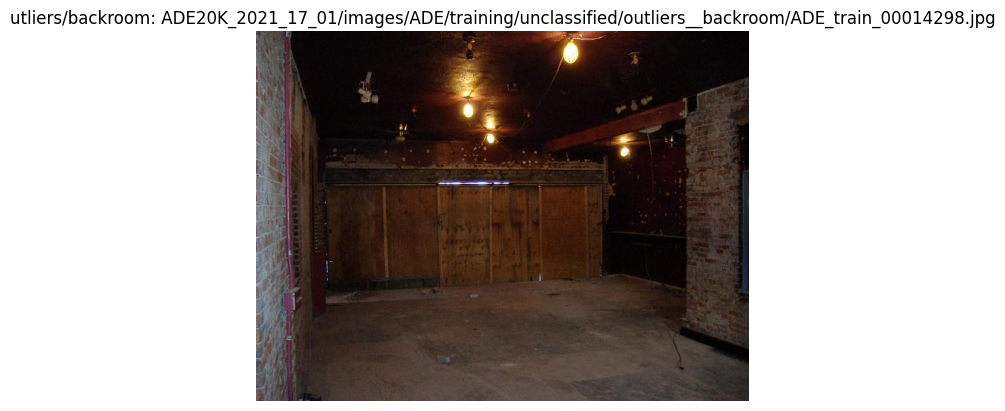

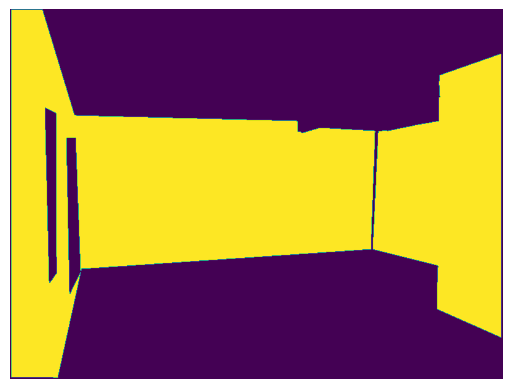

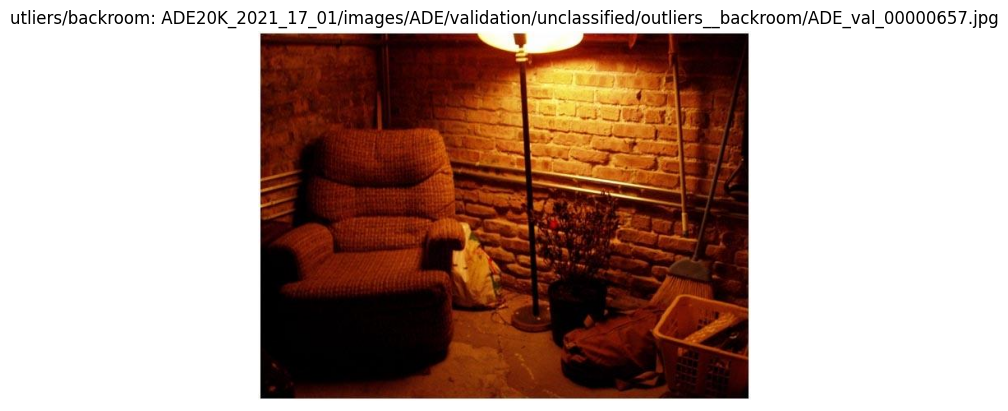

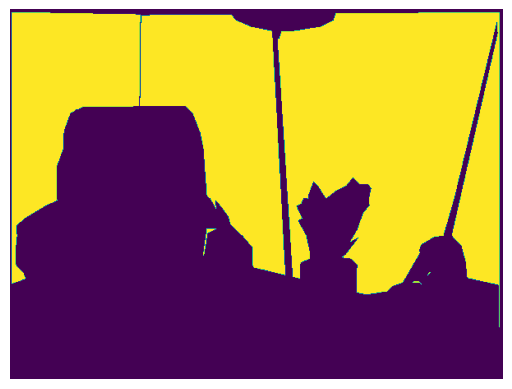

In [15]:
# TODO: explore validation dataset the same way

scene = 'utliers/backroom'
sample_indices = scene_indices[scene][:10]
print(sample_indices)
for idx in sample_indices:
    display_sample_information(all_wall_dataset, idx, show_mask=True)


In [ ]:
scene_indices = {}
for i in range(0, len(all_simple_wall_dataset)):
    scene = all_simple_wall_dataset.index['scene'][i]
    scene = scene.split('/')[0]
    if scene not in scene_indices:
        scene_indices[scene] = [i]
    else:
        scene_indices[scene].append(i)
print(f'Number of scenes: {len(scene_indices)}')
pprint(list(scene_indices.keys()))

In [ ]:
# TODO: explore validation dataset the same way

scene = 'train_station'
sample_indices = scene_indices[scene][:10]
print(sample_indices)
for idx in sample_indices:
    display_sample_information(train_simple_wall_dataset, idx, show_mask=True)


In [ ]:
val_simple_wall_dataset = SimpleWallADE20KDataset(DATA_ROOT, mode='val')
len(val_simple_wall_dataset)

In [ ]:
image, mask = val_simple_wall_dataset[0]
type(image), type(mask)

In [ ]:
plt.imshow(image.transpose((1, 2, 0)));

In [ ]:
plt.imshow(mask.reshape(512, 512));
# TODO: probably need to filter out outdoor scenes as well

In [ ]:
small_dataset = SimpleWallADE20KDataset(root=DATA_ROOT, mode="all", length=200)

In [ ]:
len(small_dataset)

In [10]:
from src import config

In [11]:
LIST_SCENES = ['bathroom', 'bedroom', 'kitchen', 'living_room', 'art_gallery', 'art_studio', 'attic', 'auditorium',
               'shop', 'ballroom', 'bank_indoor', 'banquet_hall', 'bar', 'basement', 'bookstore', 'childs_room',
               'classroom', 'room', 'closet', 'clothing_store', 'computer_room', 'conference_room', 'corridor',
               'office', 'darkroom', 'dentists_office', 'diner_indoor', 'dinette_home', 'dining_room', 'doorway_indoor',
               'dorm_room', 'dressing_room', 'entrance_hall', 'galley', 'game_room', 'garage_indoor', 'gymnasium_indoor',
               'hallway', 'home_office', 'hospital_room', 'hotel_room', 'jail_cell', 'kindergarden_classroom',
               'lecture_room', 'library_indoor', 'lobby', 'museum_indoor', 'nursery', 'playroom', 'staircase',
               'television_studio', 'utility_room', 'waiting_room', 'warehouse_indoor', 'youth_hostel']

In [12]:
len(LIST_SCENES), len(config.WALL_DATA['scenes'])

(55, 97)

In [13]:
list(set(LIST_SCENES) - config.WALL_DATA['scenes'])

['shop',
 'darkroom',
 'galley',
 'doorway_indoor',
 'clothing_store',
 'closet',
 'bank_indoor',
 'room',
 'diner_indoor',
 'library_indoor',
 'museum_indoor',
 'dinette_home',
 'warehouse_indoor',
 'gymnasium_indoor',
 'garage_indoor']

In [ ]:
all_simple_wall_dataset.index['scene'][1]

In [ ]:
all_simple_wall_dataset.index['filename'][0]